### Siamese Classifier

In [18]:
from Tumor_Classifier_Utils import *

In [19]:
data_train = scio.loadmat('Data/tumor_train_data.mat')
data_val = scio.loadmat('Data/tumor_val_data.mat')
data_test = scio.loadmat('Data/tumor_test_data.mat')

N = 64 # image size (64x64 after preprocessing)
num_classes = 4; # how many different types of classifications we have 

In [20]:
train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
train_y = data_train['labels_train']
val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
val_y = data_val['labels_val']
test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
test_y = data_test['labels_test']

print(train.shape)
print(val.shape)
print(test.shape)

(1958, 64, 64, 1)
(654, 64, 64, 1)
(654, 64, 64, 1)


In [21]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def PairGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = GetSiameseData(imgs, labels, batch_size)
        yield [image_a, image_b], label

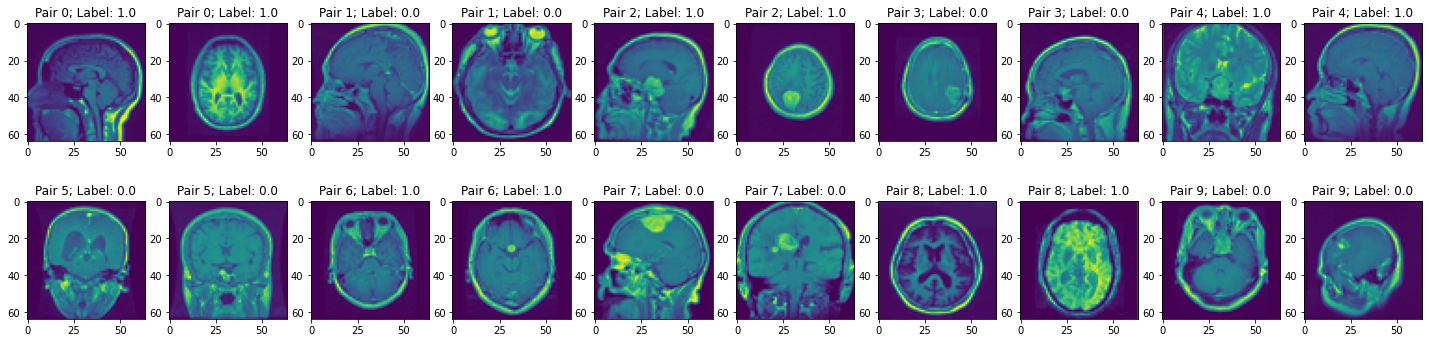

In [22]:
test_gen = PairGenerator(train, train_y, 10)
x, y = next(test_gen)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))  

## The Network

In [23]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [24]:
embedding_size = 32
dummy_input = keras.Input((N, N, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
base_network.summary()

Model: "SiameseBranch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 8)         80        
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 64, 64, 8)         0         
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 64, 64, 8)        0         
 lDropout2D)                                         

In [25]:
input_a = keras.Input((N, N, 1), name='InputA')
input_b = keras.Input((N, N, 1), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

In [26]:
combined = layers.concatenate([embedding_a, embedding_b])
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(combined)

siamese_network = keras.Model([input_a, input_b], output, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputA (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 InputB (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 SiameseBranch (Functional)     (None, 32)           2124920     ['InputA[0][0]',                 
                                                                  'InputB[0][0]']                 
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64)           0           ['SiameseBranch[0][0

In [27]:
keras.utils.plot_model(siamese_network, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
siamese_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [29]:
batch_size = 128
training_gen = PairGenerator(train, train_y, batch_size)

siamese_test_x, siamese_test_y = GetSiameseData(test, test_y, 128)

siamese_network.fit(training_gen, steps_per_epoch = 2000 // batch_size, epochs=10, validation_data = (siamese_test_x, siamese_test_y))

Epoch 1/10
15/15 [==============================] - 10s 568ms/step - loss: 0.7720 - accuracy: 0.4984 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/10
15/15 [==============================] - 9s 609ms/step - loss: 0.7102 - accuracy: 0.5177 - val_loss: 0.7032 - val_accuracy: 0.5000
Epoch 3/10
15/15 [==============================] - 9s 616ms/step - loss: 0.6955 - accuracy: 0.5302 - val_loss: 0.7191 - val_accuracy: 0.5000
Epoch 4/10
15/15 [==============================] - 10s 648ms/step - loss: 0.6793 - accuracy: 0.5667 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 5/10
15/15 [==============================] - 9s 585ms/step - loss: 0.6386 - accuracy: 0.6286 - val_loss: 0.6964 - val_accuracy: 0.4141
Epoch 6/10
15/15 [==============================] - 9s 572ms/step - loss: 0.6523 - accuracy: 0.6000 - val_loss: 0.7398 - val_accuracy: 0.5000
Epoch 7/10
15/15 [==============================] - 8s 549ms/step - loss: 0.5990 - accuracy: 0.6630 - val_loss: 0.7109 - val_accuracy: 0.5000
Epoc

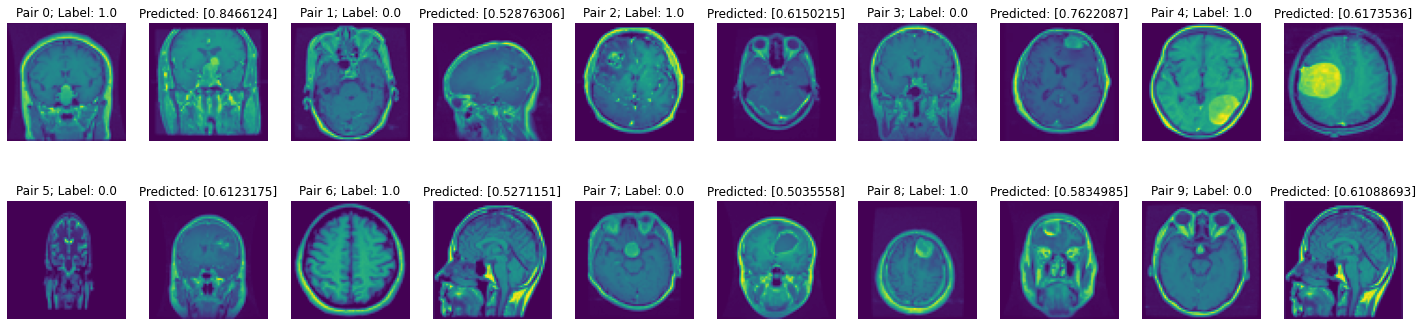

In [32]:
x, y = GetSiameseData(test, test_y, 10)
res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))
    ax.axis('off')

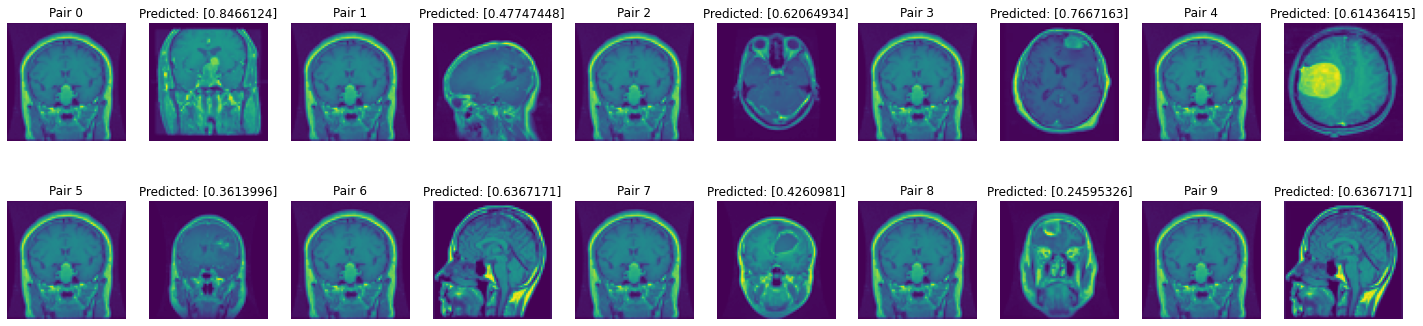

In [34]:
for i in range(10):
    x[0][i,:] = x[0][0,:]

res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i))
    ax.axis('off')
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))
    ax.axis('off')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


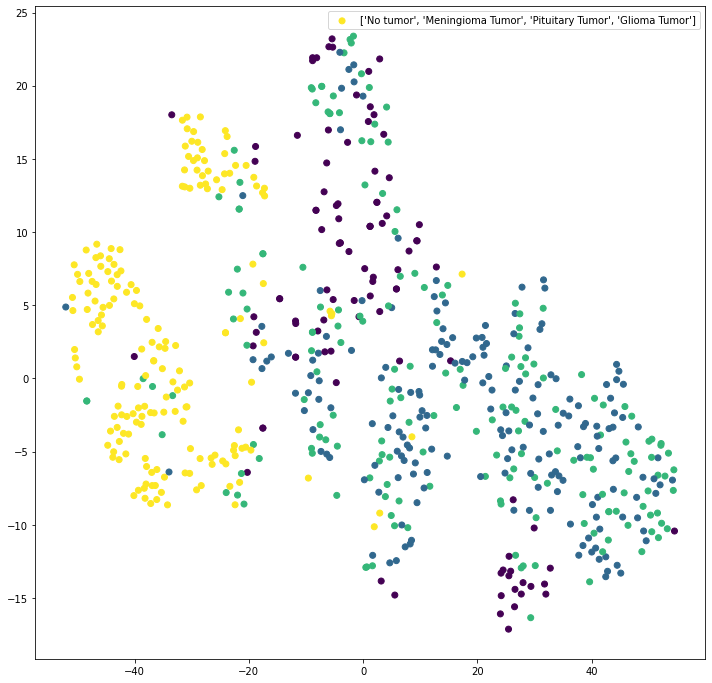

In [43]:
embeddings = base_network.predict(test)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
labels = ['No tumor', 'Meningioma Tumor', 'Pituitary Tumor', 'Glioma Tumor']
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_y.flatten(), label=labels);
plt.legend()
plt.show()

In [ ]:
embeddings_val = base_network.predict(val)
embeddings_test = base_network.predict(test)
ranked_hist = get_ranked_histogram_l1_distance(embeddings_val, val_y, embeddings_test, test_y, False)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)